<h2><center> EEG - N. 9 </center></h2>

<h3><center> MANU 465 101 </center></h3>

[Set phase](#Set-phase)

 - [Import libraries](#Import-libraries)
 - [Setting path](#Setting-path)

[Features generation](#Features-generation)


[Import procedure](#Import-procedure)
  - [Lists initialization](#Lists-initialization)
  - [Final dataset creation](#Final-dataset-creation)
       
[Conclusions](#Conclusions)
       

# Introduction


The following is the code for MANU 465 EEG Group #9 Capstone Project. The code is written in Python and uses the following libraries:

-   Pandas
-   Numpy
-   Matplotlib
-   Seaborn
-   Scikit-learn

### Objective 
Our objective is to use machine learning to determine if a person is left or right handed based on brainwave data using brainwave data collected by the MUSE 2. Muse 2 is a multi-sensor electroencephalograph (EEG) device that provides real-time biofeedback on brain activity, heartbeat, breathing, and movement by attaching a set of electrodes to the scalp to measure the electrical activity of the brain.

### Dataset
The dataset was constructed from approximately 90 test subjects. Each subject was asked to perform 4 tasks:
- 1) drawing in a circle with left hand
- 2) drawing in a circle with right hand
- 3) writing a sentence with left hand
- 4) writing a sentence with right hand

The data from each of these tasks were saved in a csv file and classified as either left hand or right hand dominant based on the test subject. Four additional features were also added for our analysis:
- 1) Participant ID
- 2) Gender
- 3) English Native speaker
- 4) left or right handed

# Set phase

### Import libraries

In [74]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

### Setting path

In [75]:
#delimiter = "\\" # for windows
delimiter = "//"  # for os system

# add your own path:

#path = r"C:/Users/chies/OneDrive/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
#path = r"/Users/sofiacaltabiano/Desktop/CLEANED DATASET- code is working/Data Collection/Unprocessed Dataset"
path = r"D:\Documents\UBC\MANU 465\MANU-465-EEG4\Unprocessed Data"

In [76]:
os.chdir(path)

Get all the filenames in the folder indicated by the previous path

In [77]:
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

In [78]:
len(all_filenames)

365

# Features generation

In order to condensate each csv file in only one row, we need to use summary metrics. 

For each wave, which corresponds to 4 columns in each file, we want one value of mean, one value of std, and so on. Then all these values will be stored in a final dataset in a unique row that represents one csv file.

In [79]:
from scipy import stats 
def mean(x):
    return np.mean(x, axis=0)
def std(x):
    return np.std(x, axis=0)
def ptp(x):
    return np.ptp(x, axis=0)
def var(x):
    return np.var(x, axis=0)
def minim(x):
    return np.min(x, axis=0)
def maxim(x):
    return np.max(x, axis=0)
def argminim(x):
    return np.argmin(x, axis=0)
def argmaxim(x):
    return np.argmax(x, axis=0)
def rms(x):
    return np.sqrt(np.mean(x**2, axis=0))
def skewness(x):
    return stats.skew(x,axis=0)
def kurtosis(x):
    return stats.kurtosis(x,axis=0)

def concatenate_features(x):
    '''''''''
    this function apply several functions defined above.
    It takes as input a numpy array.
    It outputs a vector with the value of each function: mean, std, ...
    '''''''''
    return mean(x),std(x),ptp(x),var(x),minim(x),maxim(x),argminim(x),argmaxim(x),rms(x),skewness(x),kurtosis(x)

# Import procedure

## Lists initialization

Creation of useful lists and the final dataset initialization.

The final dataset should have some columns related to information about the participant (Gender, Dominance hand, ID Number, Test, ...), 12 columns for each wave (for each wave we have mean, std, ... (in total 12 new features)). 

Since we tested each patient 4 times, the dimension of the final dataset will be:
- number rows = 4 * number of patients = number of csv files
- number columns = 12 * 5 (features * waves numbers) + fixed qualities (persona data)

In [80]:
waves = ["Delta", "Theta", "Alpha", "Beta", "Gamma"] # names of waves we are interested in

In [81]:
test_list = []
dominance_list = []
english_list = []
gender_list = []
participant_list = []

# dictionary to store all the values for one dataframe
final_dic = {}

## Final dataset creation

In [82]:
for name in all_filenames: # file 6 contains string number
    
    df = pd.read_csv(path + delimiter + name)

    df = df.drop(["Elements"], axis=1)
    df = df.dropna() # drop Nan values
    df = df.reset_index(drop=True) # restart index
    
    # Add to lists the values related to patient profile
    test_list.append(df["Test"][0])
    dominance_list.append(df["Dominance"][0])
    english_list.append(df["English"][0])
    gender_list.append(df["Gender"][0])
    participant_list.append(df["Participant"][0])

    # create empty list to collect mean, std, var, ... for a fixed wave
    gen_features = {}
    
    #print(name)
    
    for wave in waves: # for each waves (ALpha, Beta, Gamma, Delta, Theta)
        
        # create empty list to collect all the data in the four columns for a fixed wave
        all_values = []
        
        for col in df.columns: # for each column
            if col.split("_")[0] == wave: # if the wave is in the column name, then:
                
                # Marti code
                # to clean data, we delete columns in which the values is equal to the one 4 time points before
                for i in range(4,len(df[col])):
                    if not df[col][i] == df[col][i-4]:
                        all_values.append(df[col][i])
                #if len(all_values)!=0: # if the values are not constant, we want to add also the first 4 values
                #    for i in range(4):
                #        all_values.append(df[col][i])
                for i in range(4):
                    all_values.append(df[col][i])  
                    
        # add a list with the new features associated to the name of the wave in a dictionary
        gen_features[wave] = list( concatenate_features(np.array(all_values)) )
    
    final_dic[name] = gen_features
         
#print()

In [83]:
# create an empty dataframe
final_df = pd.DataFrame()

# assign to the column 'Test' of the final df all the values which are in the test_list
final_df["Test"] = test_list
final_df["English"] = english_list
final_df["Gender"] = gender_list
final_df["Participant"] = participant_list
final_df["Dominance"] = dominance_list


functions = ["mean", "std", "ptp","var","minim","maxim","argminim","argmaxim","rms","skewness","kurtosis"] 

for i in range(len(all_filenames)): # i indicates the row (index for each file)
    # Change the class from Left to Dominant or NonDominant
    if final_df.at[i, "Dominance"] == 'Left':
        if final_df.at[i, "Test"] =='LHC' or final_df.at[i, "Test"] =='LHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    else: # change the class from Right to Dominant or NonDominant
        if final_df.at[i, "Test"] =='RHC' or final_df.at[i, "Test"] =='RHS':
            final_df.at[i, "Dominance"] = 'Dominant'
        else:
            final_df.at[i, "Dominance"] = 'NonDominant'
    name = all_filenames[i]
    
    for wave in waves: # for each wave
        for j in range(11): 
            # at row i, and column specified by the name of the wave and features
            final_df.at[i, wave + "_" + functions[j]] = final_dic[name][wave][j]       
            
final_df

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,LHC,Yes,Female,101.0,Dominant,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,LHC,Yes,Male,102.0,Dominant,0.526442,0.294538,1.336331,0.086752,0.000000,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,RHS,Yes,Male,103.0,NonDominant,0.340579,0.413665,1.775144,0.171119,-0.550673,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,RHS,Yes,Male,139.0,Dominant,0.933517,0.513017,1.899951,0.263186,-0.091274,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,LHC,Yes,Male,106.0,NonDominant,0.567189,0.504123,2.265507,0.254140,-0.570804,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,RHS,Yes,Male,322.0,NonDominant,0.582510,0.434822,1.406913,0.189070,0.000000,...,0.339918,1.001319,0.115544,0.000000,1.001319,18.0,14.0,0.673433,-0.633925,-0.811194
361,RHS,No,Female,323.0,Dominant,0.504330,0.501552,1.719051,0.251554,-0.540604,...,0.473516,1.444715,0.224217,-0.550697,0.894018,14.0,31.0,0.494641,0.231307,-1.265068
362,RHS,Yes,Female,324.0,NonDominant,0.204568,0.381588,1.164488,0.145609,-0.190121,...,0.247382,0.789973,0.061198,-0.507092,0.282881,8.0,19.0,0.269017,0.040762,-1.022177
363,RHS,Yes,Female,325.0,Dominant,0.472270,0.334002,0.989795,0.111557,0.000000,...,0.216456,0.577910,0.046853,0.000000,0.577910,0.0,17.0,0.331766,0.118204,-1.506182


# Exploratory Data Analysis

A quick look at the data.

In [84]:
final_df.head()

,Test,English,Gender,Participant,Dominance,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,LHC,Yes,Female,101.0,Dominant,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,LHC,Yes,Male,102.0,Dominant,0.526442,0.294538,1.336331,0.086752,0.000000,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,RHS,Yes,Male,103.0,NonDominant,0.340579,0.413665,1.775144,0.171119,-0.550673,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,RHS,Yes,Male,139.0,Dominant,0.933517,0.513017,1.899951,0.263186,-0.091274,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,LHC,Yes,Male,106.0,NonDominant,0.567189,0.504123,2.265507,0.254140,-0.570804,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339


Reviewing Data for General Information.

In [85]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 60 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Test            365 non-null    object 
 1   English         365 non-null    object 
 2   Gender          365 non-null    object 
 3   Participant     365 non-null    float64
 4   Dominance       365 non-null    object 
 5   Delta_mean      365 non-null    float64
 6   Delta_std       365 non-null    float64
 7   Delta_ptp       365 non-null    float64
 8   Delta_var       365 non-null    float64
 9   Delta_minim     365 non-null    float64
 10  Delta_maxim     365 non-null    float64
 11  Delta_argminim  365 non-null    float64
 12  Delta_argmaxim  365 non-null    float64
 13  Delta_rms       365 non-null    float64
 14  Delta_skewness  365 non-null    float64
 15  Delta_kurtosis  365 non-null    float64
 16  Theta_mean      365 non-null    float64
 17  Theta_std       365 non-null    flo

### Check for missing values

In [86]:
# check if there are missing values
final_df.isnull().sum()


Test              0
English           0
Gender            0
Participant       0
Dominance         0
Delta_mean        0
Delta_std         0
Delta_ptp         0
Delta_var         0
Delta_minim       0
Delta_maxim       0
Delta_argminim    0
Delta_argmaxim    0
Delta_rms         0
Delta_skewness    0
Delta_kurtosis    0
Theta_mean        0
Theta_std         0
Theta_ptp         0
Theta_var         0
Theta_minim       0
Theta_maxim       0
Theta_argminim    0
Theta_argmaxim    0
Theta_rms         0
Theta_skewness    0
Theta_kurtosis    0
Alpha_mean        0
Alpha_std         0
Alpha_ptp         0
Alpha_var         0
Alpha_minim       0
Alpha_maxim       0
Alpha_argminim    0
Alpha_argmaxim    0
Alpha_rms         0
Alpha_skewness    0
Alpha_kurtosis    0
Beta_mean         0
Beta_std          0
Beta_ptp          0
Beta_var          0
Beta_minim        0
Beta_maxim        0
Beta_argminim     0
Beta_argmaxim     0
Beta_rms          0
Beta_skewness     0
Beta_kurtosis     0
Gamma_mean        0


There are no missing values in the dataset.

### Correlation Matrix

Creating a correlation matrix to see if there are any strong correlations between the features.

In [87]:
# correlation matrix
corr = final_df.corr()
# corr


Visualizing the correlation matrix.

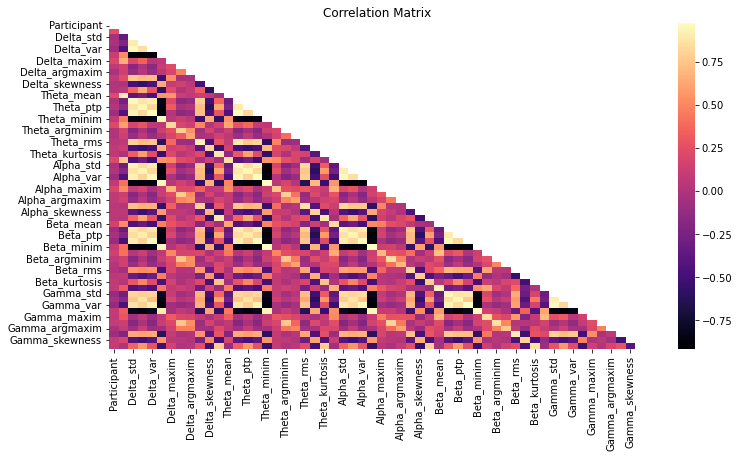

Participant       1.000000
Delta_mean        0.238136
Theta_mean        0.226362
Theta_maxim       0.219046
Alpha_mean        0.213131
Delta_maxim       0.205398
Alpha_maxim       0.195998
Beta_mean         0.156248
Beta_maxim        0.153048
Delta_minim       0.112129
Beta_minim        0.102481
Gamma_skewness    0.099409
Gamma_argminim    0.096530
Gamma_kurtosis    0.092195
Gamma_minim       0.084624
Gamma_mean        0.083544
Theta_minim       0.081340
Beta_kurtosis     0.077255
Alpha_minim       0.076951
Beta_argminim     0.074055
Delta_argminim    0.071918
Delta_rms         0.071783
Theta_skewness    0.069532
Alpha_argminim    0.068858
Alpha_argmaxim    0.068072
Gamma_maxim       0.067214
Theta_kurtosis    0.062153
Beta_skewness     0.056162
Alpha_kurtosis    0.055136
Alpha_skewness    0.054668
Alpha_rms         0.051668
Theta_rms         0.046763
Beta_argmaxim     0.029484
Theta_ptp         0.020456
Delta_kurtosis    0.016523
Theta_argminim    0.010522
Beta_rms          0.009835
A

In [88]:
# visualize the correlation matrix
from seaborn import heatmap

mask = np.triu(np.ones_like(corr, dtype=bool))  
plt.figure(figsize=(12, 6))  # to set the figure size
heatmap(corr, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")  # to add title 
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

# getting the correlation values of the features with the target
corr['Participant'].sort_values(ascending=False)

### Data Visualization

Visualize the distribution of the features.


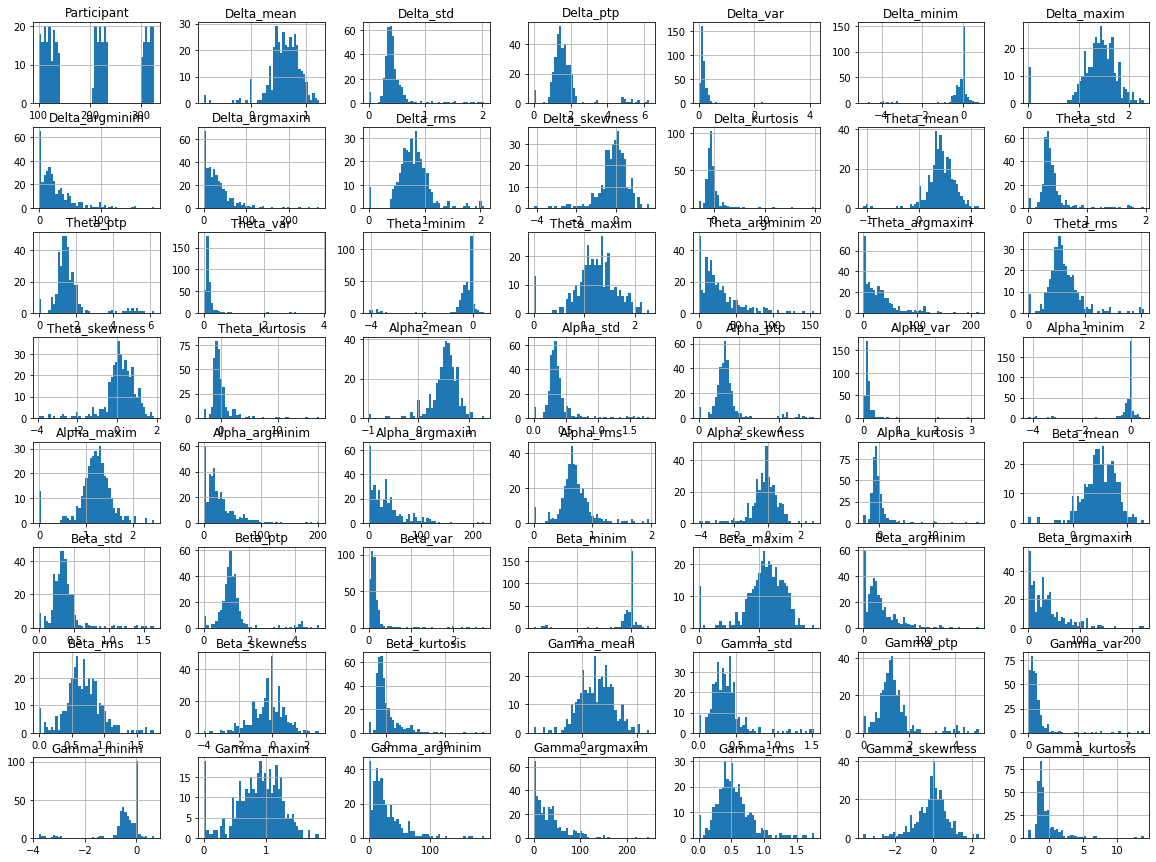

In [89]:
final_df.hist(bins=50, figsize=(20,15))
plt.show()

Distribution of the features.

c:\Users\jtsan\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


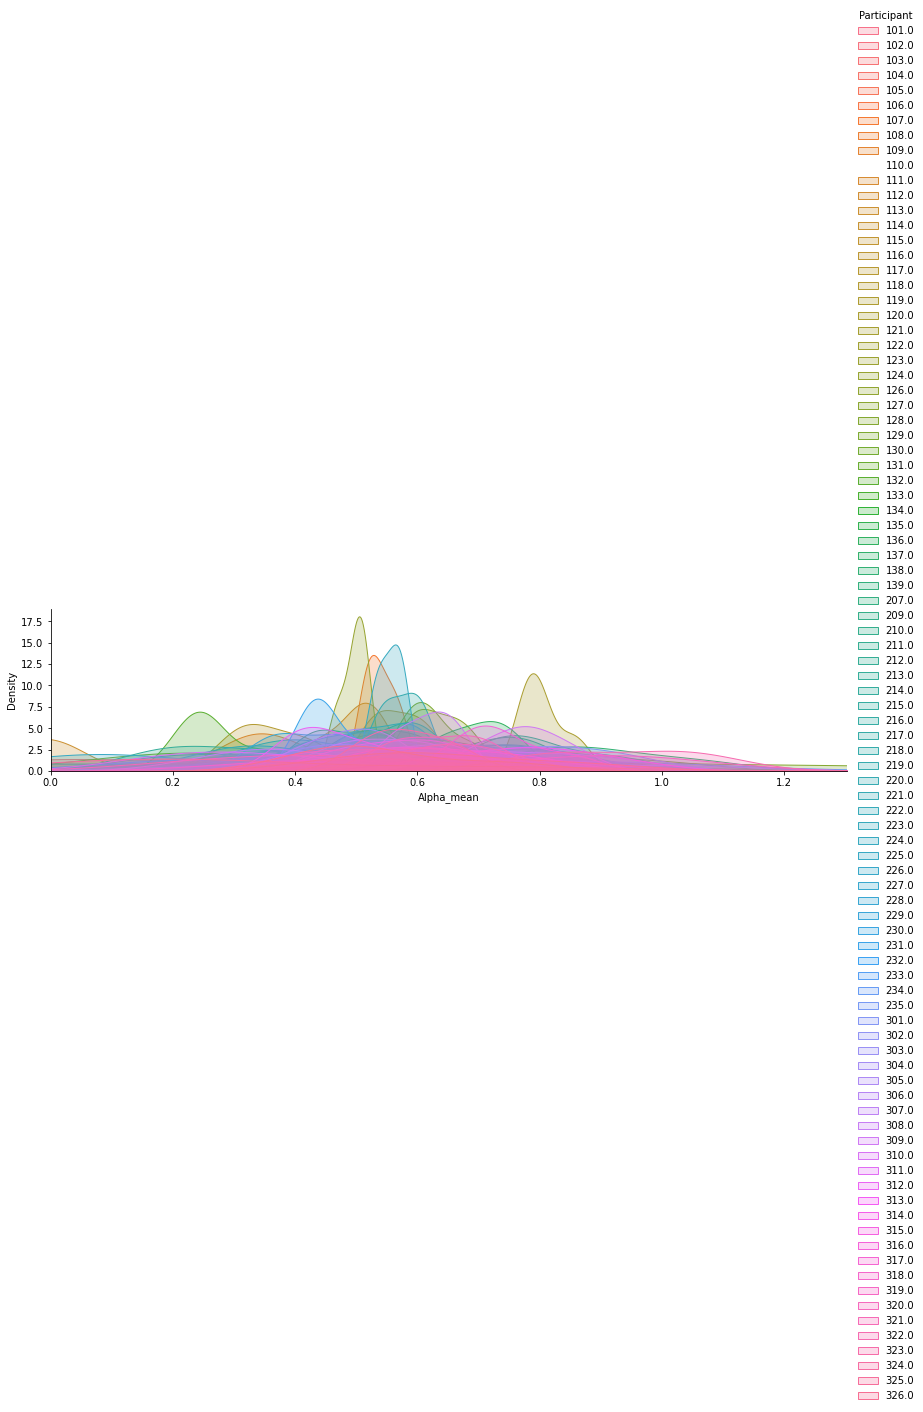

In [90]:
# make a function to plot the distribution of the features
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()
    plt.show()

# plot the distribution of the features
plot_distribution(final_df, var='Alpha_mean', target='Participant')

As we can see, the distribution of the features is not normal. We will need to normalize the data before applying the machine learning algorithms using the StandardScaler() function (see the next section).

# Data Pre-processing

Check the type of each variable

In [91]:
final_df.dtypes

Test               object
English            object
Gender             object
Participant       float64
Dominance          object
Delta_mean        float64
Delta_std         float64
Delta_ptp         float64
Delta_var         float64
Delta_minim       float64
Delta_maxim       float64
Delta_argminim    float64
Delta_argmaxim    float64
Delta_rms         float64
Delta_skewness    float64
Delta_kurtosis    float64
Theta_mean        float64
Theta_std         float64
Theta_ptp         float64
Theta_var         float64
Theta_minim       float64
Theta_maxim       float64
Theta_argminim    float64
Theta_argmaxim    float64
Theta_rms         float64
Theta_skewness    float64
Theta_kurtosis    float64
Alpha_mean        float64
Alpha_std         float64
Alpha_ptp         float64
Alpha_var         float64
Alpha_minim       float64
Alpha_maxim       float64
Alpha_argminim    float64
Alpha_argmaxim    float64
Alpha_rms         float64
Alpha_skewness    float64
Alpha_kurtosis    float64
Beta_mean   

We notice that are all float, exept English, Dominance, Gender and Test. Thus, to use these variables in several algorithms it is necessary to encode them as numeric.

Moreover we need to remember also that Participant is an id, and the value of this variable should not influence the result of the algorithm, so we are going to drop it.

## Split in X and y

In [92]:
y = final_df["Dominance"]
X = final_df.drop(["Dominance", "Participant"], axis=1)

## Encoding independent variables

In [93]:
obj_df = X.select_dtypes(include=['object']).copy()
obj_df.head()

,Test,English,Gender
0,LHC,Yes,Female
1,LHC,Yes,Male
2,RHS,Yes,Male
3,RHS,Yes,Male
4,LHC,Yes,Male


In [94]:
for col in obj_df.columns:
    X[col] = obj_df[col].astype('category').cat.codes
X.head()

,Test,English,Gender,Delta_mean,Delta_std,Delta_ptp,Delta_var,Delta_minim,Delta_maxim,Delta_argminim,...,Gamma_std,Gamma_ptp,Gamma_var,Gamma_minim,Gamma_maxim,Gamma_argminim,Gamma_argmaxim,Gamma_rms,Gamma_skewness,Gamma_kurtosis
0,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-3.000000
1,0,1,1,0.526442,0.294538,1.336331,0.086752,0.000000,1.336331,22.0,...,0.424252,1.609542,0.179990,-0.325524,1.284018,46.0,50.0,0.589387,0.181548,-1.023259
2,3,1,1,0.340579,0.413665,1.775144,0.171119,-0.550673,1.224472,56.0,...,0.463500,1.632933,0.214832,-0.614941,1.017991,35.0,108.0,0.638468,-0.662233,-1.064268
3,3,1,1,0.933517,0.513017,1.899951,0.263186,-0.091274,1.808677,47.0,...,0.397164,1.218180,0.157739,-0.067039,1.151140,19.0,41.0,0.682415,-0.174877,-1.284745
4,0,1,1,0.567189,0.504123,2.265507,0.254140,-0.570804,1.694703,50.0,...,0.630338,1.762350,0.397326,-0.568534,1.193816,47.0,91.0,0.761039,-0.310182,-1.689339


## Split in train and test

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

print("The shape of X_train is:", X_train.shape)
print("The shape of X_test is:", X_test.shape)
print('')
print("The shape of y_train is:", y_train.shape)
print("The shape of y_test is:", y_test.shape)

The shape of X_train is: (292, 58)
The shape of X_test is: (73, 58)

The shape of y_train is: (292,)
The shape of y_test is: (73,)


## Feature scaling

In [96]:
#For label data (y) always use LabelEncoder
LaEnc = LabelEncoder()
y_train = LaEnc.fit_transform(y_train)
y_train

y_test = LaEnc.transform(y_test)
y_test

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0])

In [97]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Classification analysis

## KNN

In [98]:
KNNclassifier = KNeighborsClassifier(n_neighbors = 3, metric = 'euclidean', p = 2)
KNNclassifier.fit(X_train, y_train)

y_pred = KNNclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of KNN:", acc*100,'\n')

KNNacc = acc

Confusion Matrix
[[29  8]
 [13 23]]


Accuracy of KNN: 71.23287671232876 



## SVM linear

In [99]:
SVMclassifier = SVC(kernel = 'linear', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM linear:", acc*100,'\n')

linearSVMacc = acc

Confusion Matrix
[[28  9]
 [ 7 29]]


Accuracy of SVM linear: 78.08219178082192 



## SVM non linear

In [100]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 1)
SVMclassifier.fit(X_train, y_train)

y_pred = SVMclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of SVM rbf:", acc*100,'\n')

nonlinearSVMacc = acc

Confusion Matrix
[[29  8]
 [11 25]]


Accuracy of SVM rbf: 73.97260273972603 



## Naive Bayes Classifier

In [101]:
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

y_pred = NBclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of Naive bayes Classifier:", acc*100,'\n')

NBacc = acc

Confusion Matrix
[[32  5]
 [18 18]]


Accuracy of Naive bayes Classifier: 68.4931506849315 



## Random Forest

In [102]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 1)
Forestclassifier.fit(X_train, y_train)

y_pred = Forestclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of random forest:", acc*100,'\n')

Forestacc = acc

Confusion Matrix
[[29  8]
 [11 25]]


Accuracy of random forest: 73.97260273972603 



## Decision Tree

In [103]:
DecisionTreeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DecisionTreeclassifier.fit(X_train, y_train)

y_pred = DecisionTreeclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of decision tree:", acc*100,'\n')

Decisionacc = acc

Confusion Matrix
[[28  9]
 [ 6 30]]


Accuracy of decision tree: 79.45205479452055 



## Logistic Regression Classifier

In [104]:
LRclassifier = LogisticRegression()
LRclassifier.fit(X_train, y_train)

y_pred = LRclassifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(cm)
print("\n")
print("Accuracy of logistic regression classifier:", acc*100,'\n')

LRacc = acc

Confusion Matrix
[[30  7]
 [ 7 29]]


Accuracy of logistic regression classifier: 80.82191780821918 



## LASSO Regression

In [105]:
Lassoclassifier=Lasso(alpha=0.5)
Lassoclassifier.fit(X_train, y_train)

y_pred = Lassoclassifier.predict(X_test)

#cm = confusion_matrix(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)
#print('Confusion Matrix')
#print(cm)
#print("\n")
#print("Accuracy of Lasso:", acc*100,'\n')

#LASSOacc = acc


#I am not sure how to use this regression model for classification
    #in researching it, I also came upon ridge regression, but I 
    #didn't look further into it

## Accuracy Comparison

In [106]:
print('\n'"Accuracy of KNN:", format(KNNacc*100, '.2f'))
print("Accuracy of SVM linear:", format(linearSVMacc*100, '.2f'))
print("Accuracy of SVM rbf:", format(nonlinearSVMacc*100, '.2f'))
print("Accuracy of Naive bayes Classifier:", format(NBacc*100, '.2f'))
print("Accuracy of random forest:", format(Forestacc*100, '.2f'))
print("Accuracy of decision tree:", format(Decisionacc*100, '.2f'))
print("Accuracy of logistic regression:", format(LRacc*100, '.2f'))


Accuracy of KNN: 71.23
Accuracy of SVM linear: 78.08
Accuracy of SVM rbf: 73.97
Accuracy of Naive bayes Classifier: 68.49
Accuracy of random forest: 73.97
Accuracy of decision tree: 79.45
Accuracy of logistic regression: 80.82
